# Claim Forecast

In [1]:
import pandas as pd
import os
from isoweek import Week
import numpy as np
from darts import TimeSeries
#from darts.models import Prophet as dartProphet
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import median_absolute_error as mdae
import matplotlib.pyplot as plt
from darts.metrics import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
import xgboost as xgb
import lightgbm

In [7]:
!pip show isoweek

Name: isoweek
Version: 1.3.3
Summary: Objects representing a week
Home-page: http://github.com/gisle/isoweek
Author: Gisle Aas
Author-email: gisle@aas.no
License: BSD
Location: d:\softwares\conda\userenvs\zespri\lib\site-packages
Requires: 
Required-by: 


In [2]:
class ClaimForecast:
    def __init__(self, file_path, req_columns, forecast_for_weeks, output):
        self.file_path = file_path
        self.req_columns = req_columns
        self.forecast_for_weeks = forecast_for_weeks
        self.output = output

    def read_file(self):
        format = os.path.splitext(self.file_path)[1]
        if(format=='.xlsx'):
            df = pd.read_excel(self.file_path)
        elif(format=='.csv'):
            df = pd.read_csv(self.file_path)
            for key, value in self.req_columns.items():
                assert value in list(df.columns)
            return df

    def prepare_file(self, df):
        df = self._train_preprocess_1(df)
        return df

    def _week_to_date(self, year, week):
        d = Week(year, week).monday()
        return f'{d.year}-{d.month}-{d.day}'

    def _get_season(self, date, fruit_group, Map):
        return Map[fruit_group][Week.withdate(date).week]

    def _train_preprocess_1(self, df):
        #df[self.req_columns['target']]=df[self.req_columns['target']].round(2)
        df= df[df[self.req_columns['week']]!='Totals'].copy()
        df[self.req_columns['week']] = pd.to_numeric(df[self.req_columns['week']])
        final_df = pd.DataFrame(columns=list(df.columns))
        years= list(df[self.req_columns['year']].value_counts().index)
        fruits= list(df[self.req_columns['fruit_group']].value_counts().index)
        # To handle year overflow
        for f in fruits:
            for i in years:
                t_df = df[(df[self.req_columns['year']]==i) & (df[self.req_columns['fruit_group']]==f)].copy()
                t_df.fillna(0.0, inplace=True)
                start_week = t_df[self.req_columns['week']].values[0]
                t_df[self.req_columns['year']] = t_df[self.req_columns['week']].apply(lambda x: i if x >= start_week else i+1)
                t_df['OnSeason'] = t_df[self.req_columns['target']].apply(lambda x: 1 if x > 0 else 0)
                final_df= final_df.append(t_df)
        
        # To handle missing weeks
        for f in fruits:
            for i in years:
                weeks = list(final_df[(final_df[self.req_columns['year']]==i) & (final_df[self.req_columns['fruit_group']]==f)][self.req_columns['week']].values)
                for j in range(1, 54):
                    if j not in weeks:
                        final_df = final_df.append({self.req_columns['year']: i, self.req_columns['week']:j, 
                        self.req_columns['fruit_group']: f, self.req_columns['target']: 0,
                            'OnSeason': 0}, ignore_index=True)
                assert len(final_df[(final_df[self.req_columns['year']]==i) & (final_df[self.req_columns['fruit_group']]==f)])==53
        
        final_df['ds'] = final_df.apply(lambda x: self._week_to_date(x[self.req_columns['year']], x[self.req_columns['week']]), axis=1)
        final_df['ds']= pd.to_datetime(final_df['ds'], format='%Y-%m-%d')
        final_df.reset_index(drop=True, inplace=True)
        return final_df

    def predict(self, df):
        fruits= list(df[self.req_columns['fruit_group']].value_counts().index)
        seasons_dict = {}
        prediction_df = pd.DataFrame(columns=['ds', self.req_columns['target'], f"{self.req_columns['target']}_upper", 
                                            f"{self.req_columns['target']}_lower", self.req_columns['fruit_group']])
        for f in fruits:
            seasons_dict[f] = {}
            train = df[df[self.req_columns['fruit_group']]==f].sort_values('ds')
            train= train[~train.duplicated(subset='ds')].reset_index(drop=True)
            train.to_csv(f'{f}.csv', index=False)

            # building the season mapper for fruit group 'f'
            for i in range(min(train[self.req_columns['week']]), max(train[self.req_columns['week']])+1):
                t_df= train[train[self.req_columns['week']]==i]
                prob= t_df['OnSeason'].sum()/len(t_df)
                if prob >= 0.5:
                    seasons_dict[f][i]=1
                else:
                    seasons_dict[f][i]=0

            train.rename(columns={self.req_columns['target']:'y'}, inplace=True)
            train= train[['ds', 'y', 'OnSeason']]
            m= Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
            m.add_regressor('OnSeason')
            m.fit(train)
            future = m.make_future_dataframe(periods=self.forecast_for_weeks, freq='W-Mon')
            future['OnSeason'] = train[['OnSeason']]['OnSeason'].append(future[(-1*self.forecast_for_weeks):]['ds'].apply(lambda x: self._get_season(x, f, seasons_dict)))
            forecast = m.predict(future)
            forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
            forecast = forecast[(-1*self.forecast_for_weeks):]
            forecast[self.req_columns['fruit_group']] = f
            forecast.rename(columns={'yhat':self.req_columns['target'], 'yhat_upper':f"{self.req_columns['target']}_upper", 'yhat_lower':f"{self.req_columns['target']}_lower"}, inplace=True)
            prediction_df= prediction_df.append(forecast)
        
        prediction_df['OnSeason']= prediction_df.apply(lambda x: self._get_season(x['ds'], x[self.req_columns['fruit_group']], seasons_dict), axis=1)
        prediction_df[self.req_columns['week']]= prediction_df['ds'].apply(lambda x: Week.withdate(x).week)
        prediction_df.to_csv(self.output, index=False)
        return prediction_df, seasons_dict   

In [3]:
config = {
    "file_path":"Claims, inventory and run rate\\Edited Inventory DOS and run rate 20172020_682699021.csv",
   "output_filename": "prediction.csv",
    "req_columns": {
        "year":"Supply Year",
        "fruit_group":"Fruit Group",
        "week":"Week No.",
        "target":"Customer Claims as % of Deliveries"
                },
    "forecast_weeks":52
}

In [4]:
cf = ClaimForecast(config['file_path'], config['req_columns'], config['forecast_weeks'],
                   config['output_filename'])
df = cf.read_file()
df = cf.prepare_file(df)
df, temp_dict= cf.predict(df)

## Test Models

In [11]:
fruit_group= 'HW1OB'
data= pd.read_csv(f'{fruit_group}.csv')
data.fillna(0, inplace=True)
data.rename(columns={'Customer Claims as % of Deliveries':'y'}, inplace=True)
data = data[['ds', 'y']].set_index('ds')


<AxesSubplot:xlabel='ds'>

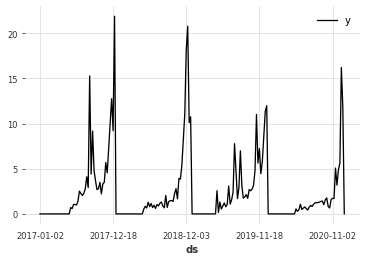

In [12]:
data.plot()

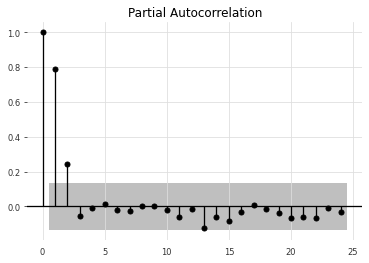

In [22]:
plot_pacf(data)
pyplot.show()

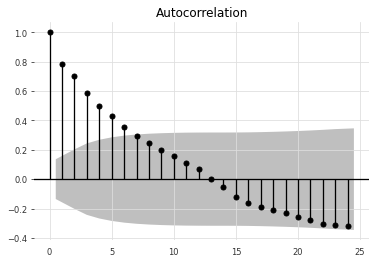

In [23]:
plot_acf(data)
pyplot.show()

### Prophet

In [30]:
def _get_season_test(date, fruit_group, Map):
    return Map[fruit_group][Week.withdate(date).week]

In [31]:
fruit_group= 'GA1CK'
data= pd.read_csv(f'{fruit_group}.csv')
data.fillna(0, inplace=True)
data.rename(columns={'Customer Claims as % of Deliveries':'y'}, inplace=True)
train, test= data[:-52], data[-52:]
train= train[['ds', 'y', 'OnSeason']]
test= test[['ds', 'y', 'OnSeason']]

m= Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False, interval_width=0.80)
m.add_regressor('OnSeason')
m.fit(train)
future = m.make_future_dataframe(periods=52, freq='W-Mon')
future['OnSeason'] = train[['OnSeason']]['OnSeason'].append(future[-52:]['ds'].apply(lambda x: _get_season_test(x, f'{fruit_group}', temp_dict)))
forecast = m.predict(future)
forecast['yhat']= forecast['yhat'].apply(lambda x: 0 if x < 0 else x)
train_forecast, test_forecast= forecast[:-52].copy(), forecast[-52:].copy()

mae_error= mae(test['y'], test_forecast['yhat'])
print('MAE Error= ',round(mae_error,2))

MAE Error=  0.89


<AxesSubplot:title={'center':'0.89'}, xlabel='ds'>

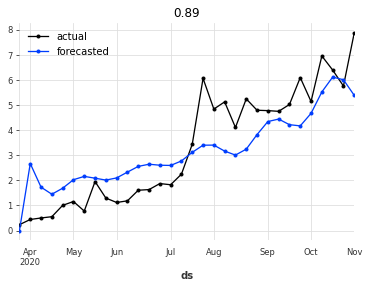

In [32]:
temp_df= pd.DataFrame({'ds':test_forecast['ds'], 'actual':test['y'].values, 'forecasted':test_forecast['yhat'].values})
temp_df= temp_df[temp_df['actual']!=0]
temp_df.set_index('ds').plot(title=f"{round(mae_error,2)}", style='.-')

In [33]:
temp_df['residuals']= temp_df['actual'] - temp_df['forecasted']
cf_data= temp_df[['ds', 'residuals']].set_index('ds')

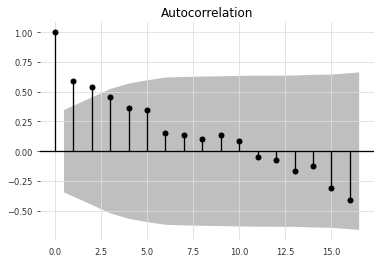

In [34]:
plot_acf(cf_data)
pyplot.show()

In [35]:
X_train= train_forecast[['trend', 'OnSeason','additive_terms','extra_regressors_additive', 'yearly']]
y_train= train['y'].values

X_test= test_forecast[['trend', 'OnSeason','additive_terms','extra_regressors_additive', 'yearly']]
#model = xgb.XGBRegressor()
model = lightgbm.LGBMRegressor()
model.fit(X_train, y_train)
y_test= model.predict(X_test)
mae_error= mae(test['y'], y_test)
print('MAE Error= ',round(mae_error,2))

MAE Error=  0.59


<AxesSubplot:title={'center':'0.59'}, xlabel='ds'>

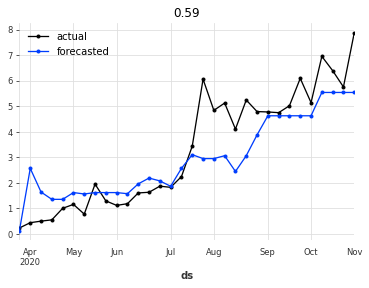

In [36]:
temp_df= pd.DataFrame({'ds':test_forecast['ds'], 'actual':test['y'].values, 'forecasted':y_test})
temp_df= temp_df[temp_df['actual']!=0]
temp_df.set_index('ds').plot(title=f"{round(mae_error,2)}", style='.-')

### Auto Arima

In [69]:
data= pd.read_csv(f'{fruit_group}.csv')
data.fillna(0, inplace=True)
data.rename(columns={'Customer Claims as % of Deliveries':'y'}, inplace=True)
train, test= data[:-52], data[-52:]
train= train[['ds', 'y', 'OnSeason']]
test= test[['ds', 'y', 'OnSeason']]

In [70]:
X_train = train[['ds', 'y']].set_index('ds')
X_train_exog = train[['OnSeason']].values

X_test = test[['ds', 'y']].set_index('ds')
X_test_exog = test[['OnSeason']].values

In [88]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(X_train, X_train_exog, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5,
                        start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12,
                        seasonal=True, error_action='warn', trace=True,
                        supress_warnings=True, stepwise=True, random_state=20,
                        n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=494.598, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=453.999, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=435.620, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=471.533, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=437.604, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=437.599, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=452.574, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=439.611, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=466.188, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=437.337, Time=0.32 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=437.441, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=441.455, Time=0.20 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=438.812, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=437.619, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,1,1)

In [89]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  157
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -213.810
Date:                            Mon, 11 Oct 2021   AIC                            435.620
Time:                                    13:03:26   BIC                            447.499
Sample:                                         0   HQIC                           440.447
                                            - 157                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7364      0.218     12.533      0.000       2.308       3.164
ma.L1         -0.5270      0.056     -9.395      0.000      -0.637      -0.417
ma.S.L12      -0.7276      0.079     -9.154      0.000      -0.883      -0.572
sigma2         1.0689      0.069     15.516      0.000       0.934       1.204
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               557.60
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(X_test), X= X_test_exog), index=X_test.index)
prediction.columns = ['forecasted']
prediction['actual'] = X_test['y']
prediction= prediction[prediction['actual']!=0]

<AxesSubplot:xlabel='ds'>

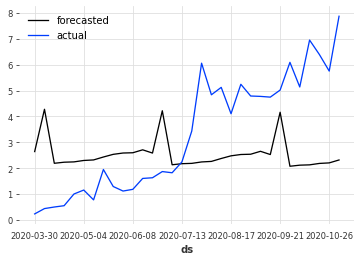

In [91]:
prediction.plot()

### Darts

In [2]:
from darts.models import ExponentialSmoothing

In [3]:
fruit_group='GA1CK'
series = TimeSeries.from_csv(f'{fruit_group}.csv', time_col='ds', value_cols=['Customer Claims as % of Deliveries']
, freq='W-Mon')
train, val = series[:-52], series[-52:]
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

D:\SOFTWARES\Conda\UserEnvs\zespri\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


0.8989722017306868

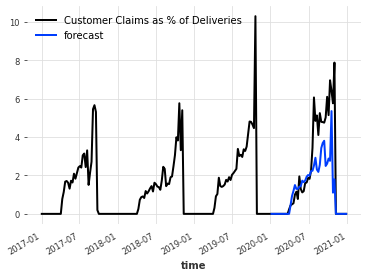

In [4]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [14]:
from darts.models.forecasting.nbeats import NBEATSModel
model = NBEATSModel(input_chunk_length=3, output_chunk_length=1)
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

[2021-10-12 09:32:13,501] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2021-10-12 09:32:13,501] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2021-10-12 09:32:13,621] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-12 09:32:13,621] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


2.0455250199314516

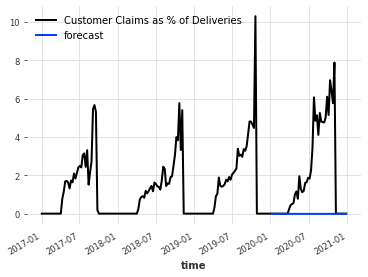

In [15]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [17]:
from darts.models.forecasting.gradient_boosted_model import LightGBMModel
model = LightGBMModel(lags=1)
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

1.9732296618296996

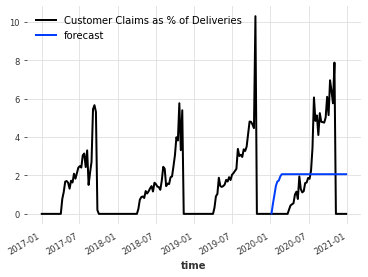

In [18]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [19]:
from darts.models.forecasting.random_forest import RandomForest
model = RandomForest(lags=3)
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

2.028721165837881

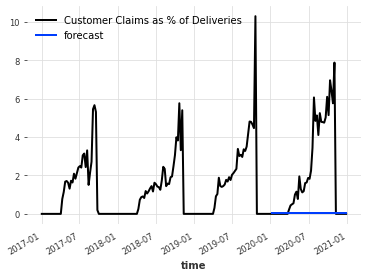

In [20]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [40]:
from darts.models.forecasting.auto_arima import AutoARIMA
model = AutoARIMA()
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

1.7981512213939677

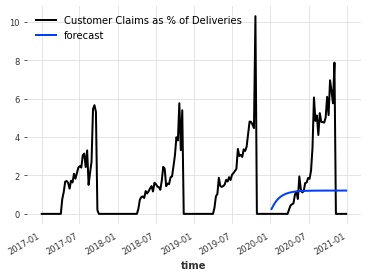

In [41]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [11]:
from darts.models.forecasting.block_rnn_model import BlockRNNModel
model = BlockRNNModel(input_chunk_length=3, output_chunk_length=1)
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

[2021-10-12 09:19:51,718] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2021-10-12 09:19:51,718] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2021-10-12 09:19:51,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-12 09:19:51,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


1.7392243442639717

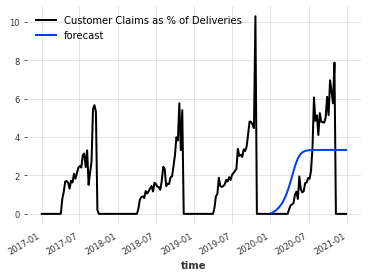

In [13]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [45]:
from darts.models.forecasting.fft import FFT
model = FFT()
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

1.1424804755063414

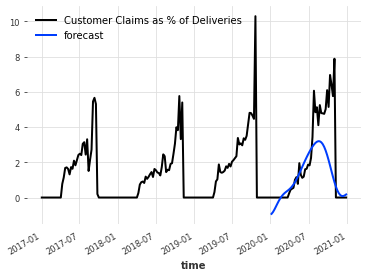

In [46]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [49]:
from darts.models.forecasting.transformer_model import TransformerModel
model = TransformerModel(input_chunk_length=3, output_chunk_length=1)
model.fit(train)
prediction = model.predict(len(val), num_samples=1)
metrics.mae(actual_series=val, pred_series=prediction)

[2021-10-11 12:21:25,896] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2021-10-11 12:21:25,896] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 154 samples.
[2021-10-11 12:21:25,932] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-11 12:21:25,932] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


1.9236296843052723

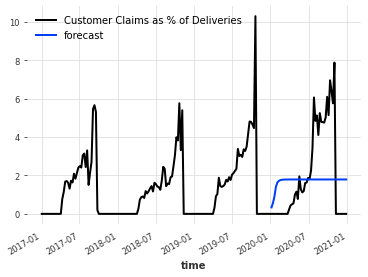

In [50]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

### Merilon

In [3]:
from merlion.utils import TimeSeries
import pandas as pd

In [9]:
fruit_group= 'GA1CK'
data= pd.read_csv(f'{fruit_group}.csv')
data.fillna(0, inplace=True)
data.rename(columns={'Customer Claims as % of Deliveries':'y'}, inplace=True)
train, test= data[:-52], data[-52:]
train= train[['ds', 'y', 'OnSeason']].set_index('ds')
test= test[['ds', 'y', 'OnSeason']].set_index('ds')

In [10]:
from merlion.models.factory import ModelFactory

In [11]:
train_data = TimeSeries.from_pd(train)

### Prophet diagnostics

In [30]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='104 W', period='2 W', horizon = '52 W')

INFO:prophet:Making 4 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-02-11 00:00:00
100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


In [37]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,35 days,96.603154,9.828690,7.991717,inf,1.812860,0.05
1,42 days,80.222620,8.956708,7.223829,inf,1.933116,0.00
2,49 days,61.335028,7.831668,6.502018,inf,1.967483,0.00
3,56 days,32.083039,5.664189,5.568206,inf,2.000000,0.00
4,63 days,33.133022,5.756129,5.651953,inf,2.000000,0.00
